# Capstone Project

**Comparison of big cities (>100.000 inhabitans) from Chile and Germany**

Let's input the credentials for Foursquare APi and setup IBM Cloud Projects (to be able to read and write files)

In [270]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
#from project_lib import Project
#project = Project(project_id='3ef43ceb-dbe9-4a5e-afd4-a499b74bc4b6', project_access_token='p-15058a173641e224fb293b039deb9f1431a752bb')
#pc = project.project_context

# @hidden_cell
CLIENT_ID = '0ONCEUND11DYFXHF4LW1GX44W4QZKFW1AU2WQMO2P5HVYTMO' # your Foursquare ID
CLIENT_SECRET = 'SPRNAOPCR0BBYZY3UYUGCOKWLUCPB3KKL3JN4P2VC0FKDE5N' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Let's install required packages and import libraries

In [271]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line to install geopy
from geopy.geocoders import Nominatim# convert an address into latitude and longitude values
from geopy.geocoders import Yandex# convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

!pip install foursquare
!pip install git+https://github.com/dacog/foursquare_api_tools.git#egg=foursquare_api_tools --upgrade --force-reinstall
#!pip install git+https://github.com/dacog/foursquare_api_tools.git#egg=foursquare_api_tools

import foursquare as fs
from foursquare_api_tools import foursquare_api_tools as ft

#some stuff to make it more interactive
import sys
import time
output_stream = sys.stdout
import time

print('Libraries imported.')

/bin/sh: 1: conda: not found
/bin/sh: 1: conda: not found
  Cloning https://github.com/dacog/foursquare_api_tools.git to /tmp/pip-install-0_59jzui/foursquare-api-tools
  Using cached https://files.pythonhosted.org/packages/e6/de/a0d3defd8f338eaf53ef716e40ef6d6c277c35d50e09b586e170169cdf0d/pandas-0.24.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/61/28/1d3920e4d1d50b19bc5d24398a7cd85cc7b9a75a490570d5a30c57622d34/pytz-2018.9-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/41/17/c62faccbfbd163c7f57f3844689e3a78bae1f403648a6afb1d0866d87fbb/python_dateutil-2.8.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f5/bf/4981bcbee43934f0adb8f764a1e70ab0ee5a448f6505bd04a87a2fda2a8b/numpy-1.16.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/73/fb/00a976f728d0d1fecfe898238ce23f502a721c0ac0ecfedb80e0d88c64e9/six-1.12.0-py2.py3-none-any.whl
  Using cached https:

## Get Data
To get all the cities I used a query on wikipedia data and saved the file on the Project GitHub Repository

In [272]:
## Get city data from github from csv file from data.wikipedia.org query with biggest cities
#url='https://raw.githubusercontent.com/dacog/Coursera_Capstone/master/query%20wikipedia%20biggest%20cities.csv'
url='https://raw.githubusercontent.com/dacog/Coursera_Capstone/master/resources/query%20wikipedia%20biggest%20cities%20with%20coordinates.csv'
df_cities = pd.read_csv(url)
df_cities.head()

,city,cityLabel,population,pa_s,pa_sLabel,coordenadas
0,http://www.wikidata.org/entity/Q8686,Shanghai,23390000,http://www.wikidata.org/entity/Q148,People's Republic of China,Point(121.466666666 31.166666666)
1,http://www.wikidata.org/entity/Q956,Beijing,21710000,http://www.wikidata.org/entity/Q148,People's Republic of China,Point(116.391388888 39.905)
2,http://www.wikidata.org/entity/Q8673,Lagos,21324000,http://www.wikidata.org/entity/Q1033,Nigeria,Point(3.4 6.45)
3,http://www.wikidata.org/entity/Q1490,Tokyo,13784212,http://www.wikidata.org/entity/Q17,Japan,Point(139.77 35.68)
4,http://www.wikidata.org/entity/Q11736,Tianjin,13245000,http://www.wikidata.org/entity/Q148,People's Republic of China,Point(117.205555555 39.146666666)


Let's check the shape of df_cities

In [273]:
print('We have',df_cities.shape[0], 'cities')

We have 2957 cities


### Clean the cities dataset

In [274]:
#rename columns
df_cities.columns=['city data link','City','Population','country data link','Country','Coordinates']
#drop empty rows
df_cities.dropna(how='any',axis=0,inplace=True)
#df = df[pd.notnull(df['Gender'])]
#split coordinates
df_cities[['Longitude','Latitude']] = df_cities['Coordinates'].str.split(' ',expand=True)
#clean coordinates
df_cities['Longitude'] = df_cities['Longitude'].str[6:]
df_cities['Latitude'] = df_cities['Latitude'].str[:-1]
#df[['V','allele']] = df['V'].str.split('-',expand=True)
df_cities=df_cities[pd.notnull(df_cities['Latitude'])]
df_cities=df_cities[pd.notnull(df_cities['Longitude'])]
df_cities.drop_duplicates()
#drop Coordinates as it's not needed anymore
df_cities.drop('Coordinates',axis=1, inplace=True)

df_cities.head()

,city data link,City,Population,country data link,Country,Longitude,Latitude
0,http://www.wikidata.org/entity/Q8686,Shanghai,23390000,http://www.wikidata.org/entity/Q148,People's Republic of China,121.466666666,31.166666666
1,http://www.wikidata.org/entity/Q956,Beijing,21710000,http://www.wikidata.org/entity/Q148,People's Republic of China,116.391388888,39.905
2,http://www.wikidata.org/entity/Q8673,Lagos,21324000,http://www.wikidata.org/entity/Q1033,Nigeria,3.4,6.45
3,http://www.wikidata.org/entity/Q1490,Tokyo,13784212,http://www.wikidata.org/entity/Q17,Japan,139.77,35.68
4,http://www.wikidata.org/entity/Q11736,Tianjin,13245000,http://www.wikidata.org/entity/Q148,People's Republic of China,117.205555555,39.146666666


## Some insights into the dataset

In [275]:
#check number of countries in dataframe
print('There are {} Countries' .format(df_cities['Country'].unique().size))

There are 167 Countries


In [276]:
#check number of cities in dataframe
print('There are {} Cities' .format(df_cities['City'].unique().size))

There are 2509 Cities


### Count the number of cities per country

In [277]:
df_cities.groupby('Country').count()

,city data link,City,Population,country data link,Longitude,Latitude
Country,,,,,,
Afghanistan,8,8,8,8,8,8
Albania,4,4,4,4,4,4
Algeria,5,5,5,5,5,5
Angola,6,6,6,6,6,6
Argentina,27,27,27,27,27,27
Armenia,2,2,2,2,2,2
Australia,15,15,15,15,15,15
Austria,7,7,7,7,7,7
Azerbaijan,3,3,3,3,3,3


We will analize only the cities of Chile and Germany

In [278]:
print('There are {} cities in Chile with more than 100.000 inhabitants' 
      .format(df_cities.loc[df_cities['Country'] == 'Chile'].shape[0]))

There are 8 cities in Chile with more than 100.000 inhabitants


In [279]:
print('There are {} cities in Germany with more than 100.000 inhabitants' 
      .format(df_cities.loc[df_cities['Country'] == 'Germany'].shape[0]))

There are 76 cities in Germany with more than 100.000 inhabitants


We have to check the columns types 

In [280]:
#Check the column types
df_cities.dtypes

city data link       object
City                 object
Population            int64
country data link    object
Country              object
Longitude            object
Latitude             object
dtype: object

Latitude and Longitude Columns have to be floats. let's fix that.

In [281]:
#Latitude and Longitude types are wrong
df_cities['Latitude']=df_cities['Latitude'].astype(float)
df_cities['Longitude']=df_cities['Longitude'].astype(float)
df_cities.dtypes

city data link        object
City                  object
Population             int64
country data link     object
Country               object
Longitude            float64
Latitude             float64
dtype: object

### Let's create a new dataset for the cities in Chile and Germany

In [282]:
#Create a new dataframe and asign Cities from Chile and Germany
df_DeCl=df_cities.loc[df_cities['Country'] == 'Chile']
df_DeCl=df_DeCl.append(df_cities.loc[df_cities['Country'] == 'Germany'])

#let's check the number of countries and cities in the new dataframe

#check number of countries in dataframe
print('There are {} Countries' .format(df_DeCl['Country'].unique().size))

#check number of cities in dataframe
print('There are {} Cities' .format(df_DeCl['City'].unique().size))

There are 2 Countries
There are 84 Cities


We will save this file for future references

In [283]:
#project.save_data(data=df_DeCl.to_csv(index=False),file_name='df_decl.csv',overwrite=False)  #creates a new file each time

## Lets create a map with the cities of Germany and Chile

In [284]:
map_world = folium.Map()

# add markers to map
for lat, lng, city in zip(df_DeCl['Latitude'], df_DeCl['Longitude'], df_DeCl['City']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_world)  
    
map_world

## Now we have to get the venues for each city.

We are interested in the results for each city for a series of categories, which we will find by using a query

In [285]:
#We can save the new dataframe for future references

#project.save_data(data=df_DeCl.to_csv(index=False),file_name='df_decl.csv',overwrite=False)  #creates a new file each time

To get the data I developed a package with a function to get the venues around a coordinate and return a dataframe. I used the foursquare package, iterated and cleaned the result and then transformed the output into a dataframe.

You can find the package at https://github.com/dacog/foursquare_api_tools

In [286]:
df_DeCl.head()

,city data link,City,Population,country data link,Country,Longitude,Latitude
1212,http://www.wikidata.org/entity/Q3612,Antofagasta,380695,http://www.wikidata.org/entity/Q298,Chile,-70.400000,-23.633333
1308,http://www.wikidata.org/entity/Q184345,Viña del Mar,334248,http://www.wikidata.org/entity/Q298,Chile,-71.533333,-33.033333
1424,http://www.wikidata.org/entity/Q33986,Valparaíso,296655,http://www.wikidata.org/entity/Q298,Chile,-71.616361,-33.045944
1639,http://www.wikidata.org/entity/Q82128,Temuco,236377,http://www.wikidata.org/entity/Q298,Chile,-72.666667,-38.750000
1724,http://www.wikidata.org/entity/Q4469,Talca,220357,http://www.wikidata.org/entity/Q298,Chile,-71.666667,-35.433333


In [287]:
# Load Venues

In [288]:
#it takes a while to get all the venues. We can read them here once saved

#uncomment to load venues from github
#df_DeCl_venues=pd.read_csv(project.get_file('venues_decl.csv'))

#uncomment to load venues from github
df_DeCl_venues=pd.read_csv('https://raw.githubusercontent.com/dacog/Coursera_Capstone/master/resources/venues_decl.csv')

df_DeCl_venues.head()

,index,Address,Category,City,Country,Latitude,Longitude,Name,Country2,City2,Query
0,0,NaN,School,NaN,Chile,-23.635031,-70.395411,Escuela República del Ecuador,Chile,Antofagasta,school
1,0,Bolivar 467,School,Antofagasta,Chile,-23.646197,-70.395763,Colegio Adventista de Antofagasta,Chile,Antofagasta,school
2,0,NaN,School,NaN,Chile,-23.647161,-70.393152,Escuela De Conductores Scorpio,Chile,Antofagasta,school
3,0,NaN,School,Antofagasta,Chile,-23.650057,-70.400556,Liceo Marta Narea,Chile,Antofagasta,school
4,0,Uribe,School,Antofagasta,Chile,-23.650438,-70.399704,Escuela de conductores magallanes,Chile,Antofagasta,school


In [289]:
#df_DeCl_venues=venues_ft

### Call foursquare api

Because Foursquare data is done by user some of the fields are/may be missing. Because of that we added the city and country to the for-loop when getting the venues as city2 and country2. We also added the query as a column to get the "main category" in which the one we will get from the api can be grouped.

In [23]:
#create an empty df
venues_ft = pd.DataFrame()
#define queries we want to pass the function. This are the categories we are interested in.
queries=['school','university','hospital','restaurant','coffee','entertainment','shops','playground','nightlife','lodging']

# Construct the client object as instructed in foursquare package
client = fs.Foursquare(client_id=CLIENT_ID, client_secret=CLIENT_SECRET, version=VERSION)

#let's print for how many cities are we going to search for venues
print('I have to look for ',df_DeCl.shape[0],' cities.')
i=0
for i in range(i,df_DeCl.shape[0]):
    lat = df_DeCl.iloc[i,df_DeCl.columns.get_loc('Latitude')]
    long = df_DeCl.iloc[i,df_DeCl.columns.get_loc('Longitude')]
    #print(lat,long)
    try:
        for query in queries:
            new_venues=ft.venues_explore(client,lat=str(lat),lng=str(long),limit=1000, offset=2,query=query)
            #foursquare give names of country and city in original langage and/or user submited of the place. We need the normal ones.
            new_venues['Country2']=df_DeCl.iloc[i,df_DeCl.columns.get_loc('Country')]
            new_venues['City2']=df_DeCl.iloc[i,df_DeCl.columns.get_loc('City')]
            new_venues['Query']=query
            venues_ft=venues_ft.append(new_venues)
            #print('shape %s\r'% venues_ft.shape) #for debug
    except:
        #print('%s\r has no data' % i) #for debug
        pass
    output_stream.write('%s\r' % i)
    output_stream.flush()

#we save the new dataframe as it takes a while to get all the venues.
#project.save_data(data=venues_ft.to_csv(index=False),file_name='venues_decl.csv',overwrite=True) #creates a new file each time

#use this in case you excecuted the for loop to get the venues from foursquare
df_DeCl_venues=venues_ft

#we save the new dataframe as it takes a while to get all the venues.
project.save_data(data=venues_ft.to_csv(index=False),file_name=str(time.time())+'_'+'venues_decl.csv',overwrite=True) #creates a new file each time

print('I got {} venues with {} columns' .format(venues_ft.shape[0],venues_ft.shape[1]))

I have to look for  84  cities.
done


Let's check the number of venues and some insights

In [290]:
print('We got {} venues using Foursquare' .format(df_DeCl_venues.shape[0]))

We got 31589 venues using Foursquare


In [291]:
print('There are {} venues in Chile' 
      .format(df_DeCl_venues.loc[df_DeCl_venues['Country2'] == 'Chile'].shape[0]))

print('There are {} venues in Germany' 
      .format(df_DeCl_venues.loc[df_DeCl_venues['Country2'] == 'Germany'].shape[0]))

There are 2072 venues in Chile
There are 29517 venues in Germany


In [292]:
print('There are {} uniques categories.'.format(len(df_DeCl_venues['Category'].unique())))

There are 346 uniques categories.


In [293]:
df_DeCl_venues.head(5)

,index,Address,Category,City,Country,Latitude,Longitude,Name,Country2,City2,Query
0,0,NaN,School,NaN,Chile,-23.635031,-70.395411,Escuela República del Ecuador,Chile,Antofagasta,school
1,0,Bolivar 467,School,Antofagasta,Chile,-23.646197,-70.395763,Colegio Adventista de Antofagasta,Chile,Antofagasta,school
2,0,NaN,School,NaN,Chile,-23.647161,-70.393152,Escuela De Conductores Scorpio,Chile,Antofagasta,school
3,0,NaN,School,Antofagasta,Chile,-23.650057,-70.400556,Liceo Marta Narea,Chile,Antofagasta,school
4,0,Uribe,School,Antofagasta,Chile,-23.650438,-70.399704,Escuela de conductores magallanes,Chile,Antofagasta,school


Let's check of all the venues have at least one value

In [294]:
df_DeCl_venues.loc[df_DeCl_venues['Category'].isna()]

,index,Address,Category,City,Country,Latitude,Longitude,Name,Country2,City2,Query


## One Hot encoding of the categories

In [295]:
# one hot encoding
cities_onehot = pd.get_dummies(df_DeCl_venues[['Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cities_onehot['City'] = df_DeCl_venues['City2'] 

# move neighborhood column to the first column
fixed_columns = [cities_onehot.columns[-1]] + list(cities_onehot.columns[:-1])
cities_onehot = cities_onehot[fixed_columns]

cities_onehot.head()

,City,ATM,Accessories Store,Adult Boutique,Adult Education Center,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Borek Place,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Business Service,Cafeteria,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Churrascaria,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Administrative Building,College Cafeteria,College Classroom,College Engineering Building,College Library,College Math Building,College Technology Building,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currywurst Joint,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Halal Restaurant,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hobby Shop,Home Service,Hookah Bar,Hospital,Hospital Ward,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kumpir Restaurant,Language School,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lottery Retailer,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical School,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Non-Profit,Noodle House,Notary,Nursery School,Office,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Supply Store,Outlet Mall,Outlet Store,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pide Place,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool Hall,Pop-Up Shop

In [296]:
#And let's examine the new dataframe size.
cities_onehot.shape

(31589, 347)

In [297]:
#cities_onehot.isna().any().shape

#cities_onehot.loc[:, cities_onehot.isna().any()]

In [298]:
#lets group by city

cities_grouped = cities_onehot.groupby('City').mean().reset_index()
cities_grouped.head()

,City,ATM,Accessories Store,Adult Boutique,Adult Education Center,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Borek Place,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Business Service,Cafeteria,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Churrascaria,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Administrative Building,College Cafeteria,College Classroom,College Engineering Building,College Library,College Math Building,College Technology Building,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currywurst Joint,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Halal Restaurant,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hobby Shop,Home Service,Hookah Bar,Hospital,Hospital Ward,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kumpir Restaurant,Language School,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lottery Retailer,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical School,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Non-Profit,Noodle House,Notary,Nursery School,Office,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Supply Store,Outlet Mall,Outlet Store,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pide Place,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool Hall,Pop-Up Shop

In [299]:
num_top_venues = 5

for city in cities_grouped['City']:
    print("----"+city+"----")
    temp = cities_grouped[cities_grouped['City'] == city].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Aachen----
                venue  freq
0                Café  0.10
1              Bakery  0.06
2                 Bar  0.05
3      Clothing Store  0.04
4  Italian Restaurant  0.04


----Antofagasta----
              venue  freq
0              Café  0.08
1  Department Store  0.05
2          Pharmacy  0.05
3        University  0.04
4        Playground  0.04


----Augsburg----
                venue  freq
0                Café  0.13
1         Supermarket  0.05
2      Clothing Store  0.04
3                 Bar  0.03
4  Italian Restaurant  0.03


----Berlin----
                   venue  freq
0                   Café  0.09
1  General Entertainment  0.06
2            Coffee Shop  0.05
3         Clothing Store  0.04
4                    Bar  0.04


----Bielefeld----
            venue  freq
0            Café  0.09
1  Clothing Store  0.05
2     Supermarket  0.05
3             Bar  0.05
4     Coffee Shop  0.04


----Bochum----
               venue  freq
0             School  0.52
1        High 

                venue  freq
0                Café  0.11
1         Supermarket  0.05
2    Insurance Office  0.04
3              Bakery  0.04
4  Italian Restaurant  0.03


----Mainz----
               venue  freq
0               Café  0.10
1        Supermarket  0.09
2  German Restaurant  0.06
3                Bar  0.04
4         Restaurant  0.03


----Mannheim----
                venue  freq
0                Café  0.16
1         Supermarket  0.05
2                 Bar  0.05
3      Clothing Store  0.05
4  Italian Restaurant  0.04


----Mönchengladbach----
             venue  freq
0           School  0.47
1  Language School  0.13
2   Private School  0.13
3  Automotive Shop  0.13
4   Driving School  0.13


----Mülheim an der Ruhr----
           venue  freq
0   Music School  0.67
1         School  0.33
2            ATM  0.00
3  Movie Theater  0.00
4     Non-Profit  0.00


----Münster----
                venue  freq
0                Café  0.19
1         Supermarket  0.06
2          University

In [300]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [301]:
#num_top_venues = len(df_DeCl_venues['Category'].unique())

num_top_venues = 20

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['City'] = cities_grouped['City']

for ind in np.arange(cities_grouped.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cities_grouped.iloc[ind, :], num_top_venues)

city_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,Aachen,Café,Bakery,Bar,Supermarket,Italian Restaurant,Clothing Store,German Restaurant,Drugstore,Coffee Shop,Pub,University,Shopping Mall,Mediterranean Restaurant,Restaurant,Vietnamese Restaurant,Gastropub,Cocktail Bar,Hospital,Playground,School
1,Antofagasta,Café,Pharmacy,Department Store,Restaurant,Playground,University,Gastropub,General Entertainment,Clothing Store,Fast Food Restaurant,Chinese Restaurant,Bar,School,Sandwich Place,Shopping Mall,Bakery,Sporting Goods Shop,Steakhouse,Coffee Shop,Food & Drink Shop
2,Augsburg,Café,Supermarket,Clothing Store,German Restaurant,Italian Restaurant,Bar,Drugstore,Turkish Restaurant,Coffee Shop,Pub,School,Mobile Phone Shop,Brewery,Nightclub,Bakery,Lounge,Beer Garden,Mexican Restaurant,Burger Joint,Restaurant
3,Berlin,Café,General Entertainment,Coffee Shop,Bar,Clothing Store,School,German Restaurant,Restaurant,Language School,Hotel Bar,Italian Restaurant,Breakfast Spot,Playground,Cocktail Bar,Medical Center,Hospital,Wine Bar,Drugstore,Lounge,Chocolate Shop
4,Bielefeld,Café,Clothing Store,Bar,Supermarket,Mediterranean Restaurant,Coffee Shop,Playground,Restaurant,Hospital,Lawyer,Italian Restaurant,Nightclub,Insurance Office,German Restaurant,Greek Restaurant,Drugstore,Pizza Place,Shopping Mall,School,Bakery


## Cluster cities

In [302]:
#df_DeCl['Population'].shape
#cities_grouped_clustering.head(5)

In [303]:
# set number of clusters
kclusters = 5

cities_grouped_clustering = cities_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cities_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0], dtype=int32)

In [304]:
# add clustering labels
city_venues_sorted.insert(0, 'Cluster Labels K-Means', kmeans.labels_)

city_merged = df_DeCl

# merge to add latitude/longitude for each neighborhood
city_merged = city_merged.join(city_venues_sorted.set_index('City'), on='City')

city_merged.head()

,city data link,City,Population,country data link,Country,Longitude,Latitude,Cluster Labels K-Means,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
1212,http://www.wikidata.org/entity/Q3612,Antofagasta,380695,http://www.wikidata.org/entity/Q298,Chile,-70.400000,-23.633333,0.0,Café,Pharmacy,Department Store,Restaurant,Playground,University,Gastropub,General Entertainment,Clothing Store,Fast Food Restaurant,Chinese Restaurant,Bar,School,Sandwich Place,Shopping Mall,Bakery,Sporting Goods Shop,Steakhouse,Coffee Shop,Food & Drink Shop
1308,http://www.wikidata.org/entity/Q184345,Viña del Mar,334248,http://www.wikidata.org/entity/Q298,Chile,-71.533333,-33.033333,0.0,University,Hospital,Café,Sushi Restaurant,Restaurant,High School,School,Fast Food Restaurant,Sandwich Place,Supermarket,Arts & Crafts Store,Playground,General Entertainment,Japanese Restaurant,Pharmacy,Diner,Grocery Store,Food,Chinese Restaurant,Shopping Mall
1424,http://www.wikidata.org/entity/Q33986,Valparaíso,296655,http://www.wikidata.org/entity/Q298,Chile,-71.616361,-33.045944,0.0,Café,Restaurant,Bar,University,Coffee Shop,Hospital,Seafood Restaurant,High School,Nightclub,Pub,School,Supermarket,Pharmacy,Pizza Place,General Entertainment,Italian Restaurant,Grocery Store,Gastropub,Department Store,Fast Food Restaurant
1639,http://www.wikidata.org/entity/Q82128,Temuco,236377,http://www.wikidata.org/entity/Q298,Chile,-72.666667,-38.750000,2.0,High School,Nursery School,School,Zoo,Electronics Store,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Elementary School,Dive Shop,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service
1724,http://www.wikidata.org/entity/Q4469,Talca,220357,http://www.wikidata.org/entity/Q298,Chile,-71.666667,-35.433333,0.0,Café,Restaurant,Coffee Shop,Department Store,High School,Shopping Mall,Pharmacy,Playground,School,University,Grocery Store,Hot Dog Joint,Sushi Restaurant,Pizza Place,Hospital,Supermarket,Bar,Fast Food Restaurant,Chinese Restaurant,Cocktail Bar


In [305]:
city_merged['Cluster Labels K-Means'].unique()

array([ 0.,  2.,  1.,  3., nan,  4.])

In [306]:
city_merged.loc[city_merged['Cluster Labels K-Means'].isnull()]

,city data link,City,Population,country data link,Country,Longitude,Latitude,Cluster Labels K-Means,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
578,http://www.wikidata.org/entity/Q1726,Munich,1464301,http://www.wikidata.org/entity/Q183,Germany,11.575500,48.137194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1775,http://www.wikidata.org/entity/Q2838,Oberhausen,211382,http://www.wikidata.org/entity/Q183,Germany,6.850000,51.550000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2117,http://www.wikidata.org/entity/Q2938,Leverkusen,163113,http://www.wikidata.org/entity/Q183,Germany,6.983333,51.033333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2651,http://www.wikidata.org/entity/Q3069,Bottrop,117409,http://www.wikidata.org/entity/Q183,Germany,6.922778,51.524722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [307]:
city_merged=city_merged[np.isfinite(city_merged['Cluster Labels K-Means'])]

In [308]:
city_merged.loc[city_merged['Cluster Labels K-Means'].isnull()]

,city data link,City,Population,country data link,Country,Longitude,Latitude,Cluster Labels K-Means,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue


Finally, let's visualize the resulting clusters

In [309]:
# create map
map_clusters = folium.Map()

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_merged['Latitude'], city_merged['Longitude'], city_merged['City'], city_merged['Cluster Labels K-Means']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

In [310]:
city_merged.loc[city_merged['Cluster Labels K-Means'] == 0, 
                     city_merged.columns[[1] + list(range(5, city_merged.shape[1]))]]

,City,Longitude,Latitude,Cluster Labels K-Means,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
1212,Antofagasta,-70.400000,-23.633333,0.0,Café,Pharmacy,Department Store,Restaurant,Playground,University,Gastropub,General Entertainment,Clothing Store,Fast Food Restaurant,Chinese Restaurant,Bar,School,Sandwich Place,Shopping Mall,Bakery,Sporting Goods Shop,Steakhouse,Coffee Shop,Food & Drink Shop
1308,Viña del Mar,-71.533333,-33.033333,0.0,University,Hospital,Café,Sushi Restaurant,Restaurant,High School,School,Fast Food Restaurant,Sandwich Place,Supermarket,Arts & Crafts Store,Playground,General Entertainment,Japanese Restaurant,Pharmacy,Diner,Grocery Store,Food,Chinese Restaurant,Shopping Mall
1424,Valparaíso,-71.616361,-33.045944,0.0,Café,Restaurant,Bar,University,Coffee Shop,Hospital,Seafood Restaurant,High School,Nightclub,Pub,School,Supermarket,Pharmacy,Pizza Place,General Entertainment,Italian Restaurant,Grocery Store,Gastropub,Department Store,Fast Food Restaurant
1724,Talca,-71.666667,-35.433333,0.0,Café,Restaurant,Coffee Shop,Department Store,High School,Shopping Mall,Pharmacy,Playground,School,University,Grocery Store,Hot Dog Joint,Sushi Restaurant,Pizza Place,Hospital,Supermarket,Bar,Fast Food Restaurant,Chinese Restaurant,Cocktail Bar
2678,Punta Arenas,-70.916667,-53.150000,0.0,Café,Restaurant,General Entertainment,Bar,School,Department Store,Pub,Sandwich Place,Food & Drink Shop,Pharmacy,Seafood Restaurant,Gastropub,Snack Place,Pizza Place,Playground,Bakery,Tea Room,BBQ Joint,Coffee Shop,University
274,Berlin,13.383333,52.516667,0.0,Café,General Entertainment,Coffee Shop,Bar,Clothing Store,School,German Restaurant,Restaurant,Language School,Hotel Bar,Italian Restaurant,Breakfast Spot,Playground,Cocktail Bar,Medical Center,Hospital,Wine Bar,Drugstore,Lounge,Chocolate Shop
501,Hamburg,10.000000,53.550000,0.0,Café,Coffee Shop,Bar,Clothing Store,School,German Restaurant,Cocktail Bar,Restaurant,University,Italian Restaurant,Language School,Drugstore,General Entertainment,French Restaurant,Hotel Bar,Burger Joint,Furniture / Home Store,Supermarket,Nightclub,Gastropub
677,Cologne,6.957778,50.942222,0.0,Café,Clothing Store,German Restaurant,Italian Restaurant,Coffee Shop,Bar,General Entertainment,Cocktail Bar,Restaurant,Pub,Brewery,Supermarket,School,Modern European Restaurant,Bakery,Drugstore,University,Hospital,Gastropub,Furniture / Home Store
820,Frankfurt,8.679722,50.113611,0.0,Café,Bar,Restaurant,Coffee Shop,Clothing Store,Supermarket,German Restaurant,Drugstore,Hospital,Italian Restaurant,Language School,Cocktail Bar,School,Boutique,Gastropub,Nightclub,University,Thai Restaurant,Pub,Lounge
895,Stuttgart,9.177500,48.776111,0.0,Café,Bar,German Restaurant,Clothing Store,Italian Restaurant,School,Coffee Shop,Supermarket,Hospital,Nightclub,University,Restaurant,General Entertainment,Cocktail Bar,Drugstore,Lounge,Donut Shop,Gastropub,Electronics Store,Pub


In [311]:
city_merged.loc[city_merged['Cluster Labels K-Means'] == 1, 
                     city_merged.columns[[1] + list(range(5, city_merged.shape[1]))]]

,City,Longitude,Latitude,Cluster Labels K-Means,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
1839,Coquimbo,-71.333333,-29.950000,1.0,School,High School,Music School,Zoo,Electronics Store,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Elementary School,Doctor's Office,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space
916,Düsseldorf,6.810000,51.228890,1.0,School,Language School,High School,University,Music School,Private School,College Academic Building,Student Center,Music Store,Elementary School,Market,Electronics Store,Emergency Room,Doctor's Office,Empanada Restaurant,Dumpling Restaurant,Dry Cleaner,Drugstore,English Restaurant,Driving School
960,Bremen,8.808889,53.076944,1.0,School,High School,Music School,Language School,Adult Education Center,Nursery School,Private School,Driving School,Trade School,Zoo,Dry Cleaner,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Dumpling Restaurant,Dive Shop,Electronics Store,Elementary School,Emergency Room
1241,Bochum,7.216667,51.483333,1.0,School,High School,Elementary School,Driving School,Middle School,Music School,Electronics Store,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Zoo,Doctor's Office,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service
1272,Wuppertal,7.172780,51.260560,1.0,School,High School,Music School,University,Language School,Driving School,Electronics Store,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Zoo,Doctor's Office,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant
1546,Mönchengladbach,6.433333,51.200000,1.0,School,Private School,Automotive Shop,Driving School,Language School,Ethiopian Restaurant,Entertainment Service,Doner Restaurant,Exhibit,Donut Shop,Event Space,Drugstore,Dry Cleaner,Dumpling Restaurant,Event Service,Eastern European Restaurant,Electronics Store,Doctor's Office,Elementary School,Emergency Room
1929,Hagen,7.475000,51.359444,1.0,School,Music School,High School,Zoo,Electronics Store,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Elementary School,Doctor's Office,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space
2059,Mülheim an der Ruhr,6.878889,51.428333,1.0,Music School,School,Zoo,Electronics Store,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Elementary School,Doctor's Office,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit
2156,Solingen,7.083333,51.166667,1.0,School,Language School,High School,Music School,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Zoo,Doctor's Office,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service
2546,Offenbach am Main,8.766667,50.100000,1.0,School,Music School,Adult Boutique,Driving School,High School,Zoo,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Emergency Room,Elementary School,Doctor's Office,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service


In [312]:
city_merged.loc[city_merged['Cluster Labels K-Means'] == 3, 
                     city_merged.columns[[1] + list(range(5, city_merged.shape[1]))]]

,City,Longitude,Latitude,Cluster Labels K-Means,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
1908,Iquique,-70.166667,-20.216667,3.0,School,University,High School,Zoo,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Dive Shop,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service
2390,Ingolstadt,11.426111,48.763611,3.0,University,Language School,School,Electronics Store,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Zoo,Dive Shop,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service
2557,Wolfsburg,10.787222,52.423056,3.0,University,School,Language School,High School,Middle School,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Zoo,Elementary School,Doctor's Office,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant
2939,Cottbus,14.334167,51.760556,3.0,University,School,Driving School,Language School,High School,Adult Education Center,Nursery School,Zoo,Eastern European Restaurant,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Elementary School,Electronics Store,Dive Shop,Emergency Room,Empanada Restaurant,English Restaurant


In [313]:
city_merged.loc[city_merged['Cluster Labels K-Means'] == 4, 
                     city_merged.columns[[1] + list(range(5, city_merged.shape[1]))]]

,City,Longitude,Latitude,Cluster Labels K-Means,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
2606,Recklinghausen,7.200000,51.616667,4.0,School,High School,Zoo,Electronics Store,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Elementary School,Dive Shop,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space
2693,Reutlingen,9.216667,48.483333,4.0,School,Zoo,Electronics Store,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Elementary School,Dive Shop,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit
2868,Salzgitter,10.405849,52.153657,4.0,School,Zoo,Electronics Store,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Elementary School,Dive Shop,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit


## Now lets cluster not with Foursquare categories but our own queries

In [314]:
df_DeCl_venues.groupby('City2').count()

,index,Address,Category,City,Country,Latitude,Longitude,Name,Country2,Query
City2,,,,,,,,,,
Aachen,671,602,671,656,671,671,671,671,671,671
Antofagasta,365,249,365,289,365,365,365,365,365,365
Augsburg,585,492,585,585,585,585,585,585,585,585
Berlin,1033,1007,1033,1029,1033,1033,1033,1033,1033,1033
Bielefeld,427,377,427,425,427,427,427,427,427,427
Bochum,29,29,29,29,29,29,29,29,29,29
Bonn,737,692,737,734,737,737,737,737,737,737
Bremen,31,31,31,31,31,31,31,31,31,31
Bremerhaven,227,182,227,227,227,227,227,227,227,227


In [315]:
df_DeCl_venues.head()

,index,Address,Category,City,Country,Latitude,Longitude,Name,Country2,City2,Query
0,0,NaN,School,NaN,Chile,-23.635031,-70.395411,Escuela República del Ecuador,Chile,Antofagasta,school
1,0,Bolivar 467,School,Antofagasta,Chile,-23.646197,-70.395763,Colegio Adventista de Antofagasta,Chile,Antofagasta,school
2,0,NaN,School,NaN,Chile,-23.647161,-70.393152,Escuela De Conductores Scorpio,Chile,Antofagasta,school
3,0,NaN,School,Antofagasta,Chile,-23.650057,-70.400556,Liceo Marta Narea,Chile,Antofagasta,school
4,0,Uribe,School,Antofagasta,Chile,-23.650438,-70.399704,Escuela de conductores magallanes,Chile,Antofagasta,school


In [316]:
# one hot encoding
cities_onehot_query = pd.get_dummies(df_DeCl_venues[['Query']], prefix="", prefix_sep="")

# add city column back to dataframe
cities_onehot_query['City'] = df_DeCl_venues['City2'] 

# move city column to the first column
fixed_columns = [cities_onehot_query.columns[-1]] + list(cities_onehot_query.columns[:-1])
cities_onehot_query = cities_onehot_query[fixed_columns]

cities_onehot_query.head()

,City,coffee,entertainment,hospital,nightlife,playground,restaurant,school,shops,university
0,Antofagasta,0,0,0,0,0,0,1,0,0
1,Antofagasta,0,0,0,0,0,0,1,0,0
2,Antofagasta,0,0,0,0,0,0,1,0,0
3,Antofagasta,0,0,0,0,0,0,1,0,0
4,Antofagasta,0,0,0,0,0,0,1,0,0


In [317]:
#lets group by city

cities_grouped_query = cities_onehot_query.groupby('City').mean().reset_index()
cities_grouped_query.head()

,City,coffee,entertainment,hospital,nightlife,playground,restaurant,school,shops,university
0,Aachen,0.138599,0.010432,0.013413,0.168405,0.013413,0.298063,0.034277,0.298063,0.025335
1,Antofagasta,0.063014,0.030137,0.013699,0.090411,0.035616,0.298630,0.046575,0.386301,0.035616
2,Augsburg,0.121368,0.011966,0.008547,0.169231,0.005128,0.305983,0.035897,0.329915,0.011966
3,Berlin,0.193611,0.070668,0.033882,0.193611,0.024201,0.193611,0.091965,0.193611,0.004840
4,Bielefeld,0.124122,0.016393,0.025761,0.114754,0.035129,0.288056,0.025761,0.358314,0.011710


In [318]:
num_top_venues = 5

for city in cities_grouped_query['City']:
    print("----"+city+"----")
    temp = cities_grouped_query[cities_grouped_query['City'] == city].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Aachen----
        venue  freq
0  restaurant  0.30
1       shops  0.30
2   nightlife  0.17
3      coffee  0.14
4      school  0.03


----Antofagasta----
        venue  freq
0       shops  0.39
1  restaurant  0.30
2   nightlife  0.09
3      coffee  0.06
4      school  0.05


----Augsburg----
        venue  freq
0       shops  0.33
1  restaurant  0.31
2   nightlife  0.17
3      coffee  0.12
4      school  0.04


----Berlin----
        venue  freq
0      coffee  0.19
1   nightlife  0.19
2  restaurant  0.19
3       shops  0.19
4      school  0.09


----Bielefeld----
        venue  freq
0       shops  0.36
1  restaurant  0.29
2      coffee  0.12
3   nightlife  0.11
4  playground  0.04


----Bochum----
           venue  freq
0         school   1.0
1         coffee   0.0
2  entertainment   0.0
3       hospital   0.0
4      nightlife   0.0


----Bonn----
        venue  freq
0  restaurant  0.27
1       shops  0.27
2   nightlife  0.18
3      coffee  0.15
4      school  0.05


----Bremen----


           venue  freq
0          shops  0.40
1     restaurant  0.34
2         coffee  0.10
3         school  0.07
4  entertainment  0.04


----Osnabrück----
        venue  freq
0       shops  0.46
1  restaurant  0.31
2      coffee  0.13
3      school  0.03
4  university  0.03


----Pforzheim----
           venue  freq
0         school   1.0
1         coffee   0.0
2  entertainment   0.0
3       hospital   0.0
4      nightlife   0.0


----Potsdam----
        venue  freq
0       shops  0.40
1  restaurant  0.30
2      coffee  0.15
3   nightlife  0.06
4      school  0.03


----Punta Arenas----
        venue  freq
0  restaurant  0.40
1       shops  0.20
2   nightlife  0.15
3      coffee  0.08
4      school  0.06


----Recklinghausen----
           venue  freq
0         school   1.0
1         coffee   0.0
2  entertainment   0.0
3       hospital   0.0
4      nightlife   0.0


----Regensburg----
           venue  freq
0          shops  0.37
1     restaurant  0.36
2         coffee  0.19
3      

In [319]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted_query = pd.DataFrame(columns=columns)
city_venues_sorted_query['City'] = cities_grouped_query['City']

for ind in np.arange(cities_grouped_query.shape[0]):
    city_venues_sorted_query.iloc[ind, 1:] = return_most_common_venues(cities_grouped_query.iloc[ind, :], num_top_venues)

city_venues_sorted_query.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Aachen,shops,restaurant,nightlife,coffee,school
1,Antofagasta,shops,restaurant,nightlife,coffee,school
2,Augsburg,shops,restaurant,nightlife,coffee,school
3,Berlin,shops,restaurant,nightlife,coffee,school
4,Bielefeld,shops,restaurant,coffee,nightlife,playground


In [320]:
# set number of clusters
kclusters = 5

cities_grouped_clustering_query = cities_grouped_query.drop('City', 1)

# run k-means clustering
kmeans_q = KMeans(n_clusters=kclusters, random_state=0).fit(cities_grouped_clustering_query)

# check cluster labels generated for each row in the dataframe
kmeans_q.labels_[0:10] 

array([3, 1, 3, 3, 1, 2, 3, 2, 4, 3], dtype=int32)

In [321]:
# add clustering labels
city_venues_sorted_query.insert(0, 'Cluster Labels K-Means Query', kmeans.labels_)

city_merged_query = df_DeCl

# merge to add latitude/longitude for each neighborhood
city_merged_query = city_merged_query.join(city_venues_sorted_query.set_index('City'), on='City')

city_merged_query.head()

,city data link,City,Population,country data link,Country,Longitude,Latitude,Cluster Labels K-Means Query,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1212,http://www.wikidata.org/entity/Q3612,Antofagasta,380695,http://www.wikidata.org/entity/Q298,Chile,-70.400000,-23.633333,0.0,shops,restaurant,nightlife,coffee,school
1308,http://www.wikidata.org/entity/Q184345,Viña del Mar,334248,http://www.wikidata.org/entity/Q298,Chile,-71.533333,-33.033333,0.0,restaurant,university,shops,school,hospital
1424,http://www.wikidata.org/entity/Q33986,Valparaíso,296655,http://www.wikidata.org/entity/Q298,Chile,-71.616361,-33.045944,0.0,restaurant,shops,nightlife,coffee,university
1639,http://www.wikidata.org/entity/Q82128,Temuco,236377,http://www.wikidata.org/entity/Q298,Chile,-72.666667,-38.750000,2.0,school,university,shops,restaurant,playground
1724,http://www.wikidata.org/entity/Q4469,Talca,220357,http://www.wikidata.org/entity/Q298,Chile,-71.666667,-35.433333,0.0,restaurant,shops,coffee,school,nightlife


In [322]:
city_merged_query['Cluster Labels K-Means Query'].unique()

array([ 0.,  2.,  1.,  3., nan,  4.])

In [323]:
city_merged_query.loc[city_merged_query['Cluster Labels K-Means Query'].isnull()]

,city data link,City,Population,country data link,Country,Longitude,Latitude,Cluster Labels K-Means Query,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
578,http://www.wikidata.org/entity/Q1726,Munich,1464301,http://www.wikidata.org/entity/Q183,Germany,11.575500,48.137194,NaN,NaN,NaN,NaN,NaN,NaN
1775,http://www.wikidata.org/entity/Q2838,Oberhausen,211382,http://www.wikidata.org/entity/Q183,Germany,6.850000,51.550000,NaN,NaN,NaN,NaN,NaN,NaN
2117,http://www.wikidata.org/entity/Q2938,Leverkusen,163113,http://www.wikidata.org/entity/Q183,Germany,6.983333,51.033333,NaN,NaN,NaN,NaN,NaN,NaN
2651,http://www.wikidata.org/entity/Q3069,Bottrop,117409,http://www.wikidata.org/entity/Q183,Germany,6.922778,51.524722,NaN,NaN,NaN,NaN,NaN,NaN


In [324]:
city_merged_query=city_merged_query[np.isfinite(city_merged_query['Cluster Labels K-Means Query'])]

In [325]:
city_merged_query.loc[city_merged_query['Cluster Labels K-Means Query'].isnull()]

,city data link,City,Population,country data link,Country,Longitude,Latitude,Cluster Labels K-Means Query,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue


Finally, let's visualize the resulting clusters

In [326]:
# create map
map_clusters_q = folium.Map()

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_merged_query['Latitude'], city_merged_query['Longitude'], city_merged_query['City'], city_merged_query['Cluster Labels K-Means Query']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(map_clusters_q)
       
map_clusters_q

## Hierarchical cluster analysis

In [327]:
X = cities_grouped.drop('City', axis=1)
X.head()

,ATM,Accessories Store,Adult Boutique,Adult Education Center,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Borek Place,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Business Service,Cafeteria,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Churrascaria,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Administrative Building,College Cafeteria,College Classroom,College Engineering Building,College Library,College Math Building,College Technology Building,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currywurst Joint,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Halal Restaurant,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hobby Shop,Home Service,Hookah Bar,Hospital,Hospital Ward,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kumpir Restaurant,Language School,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lottery Retailer,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical School,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Non-Profit,Noodle House,Notary,Nursery School,Office,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Supply Store,Outlet Mall,Outlet Store,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pide Place,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool Hall,Pop-Up Shop,Port

In [328]:
X.shape

(80, 346)

<function matplotlib.pyplot.show(*args, **kw)>

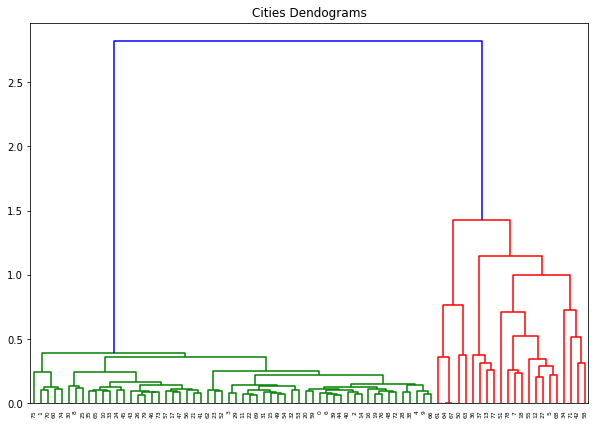

In [329]:
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))  
plt.title("Cities Dendograms")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))  
plt.show

This looks interesting. Let's apply hierarchical clustering with different linkage

<Figure size 432x288 with 0 Axes>

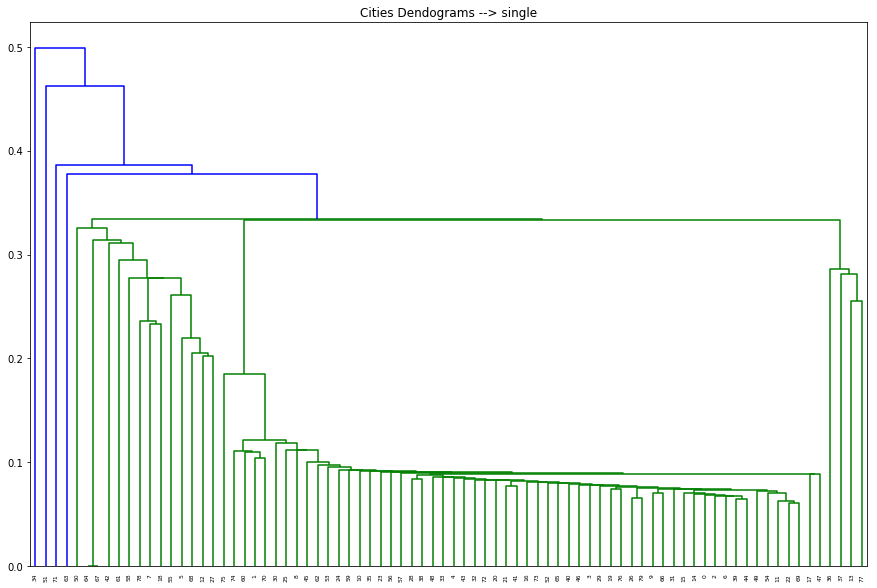

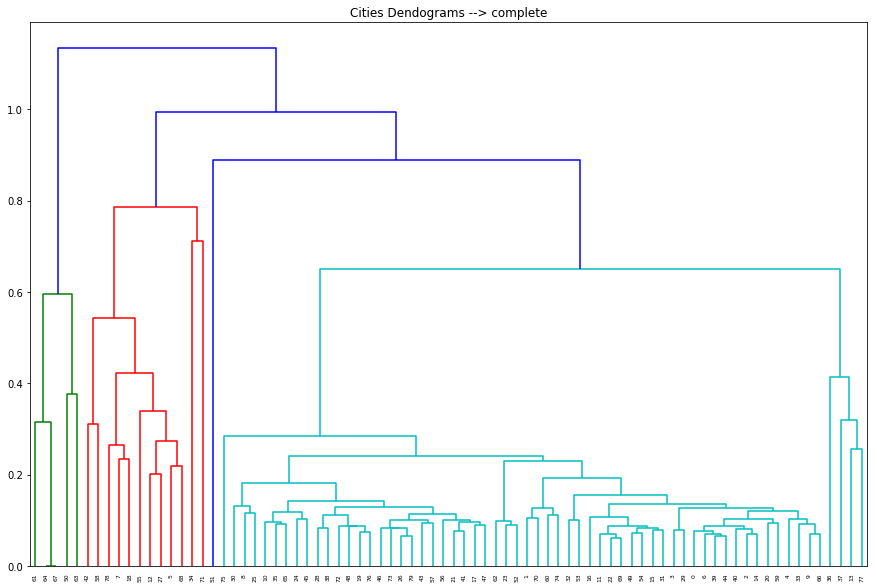

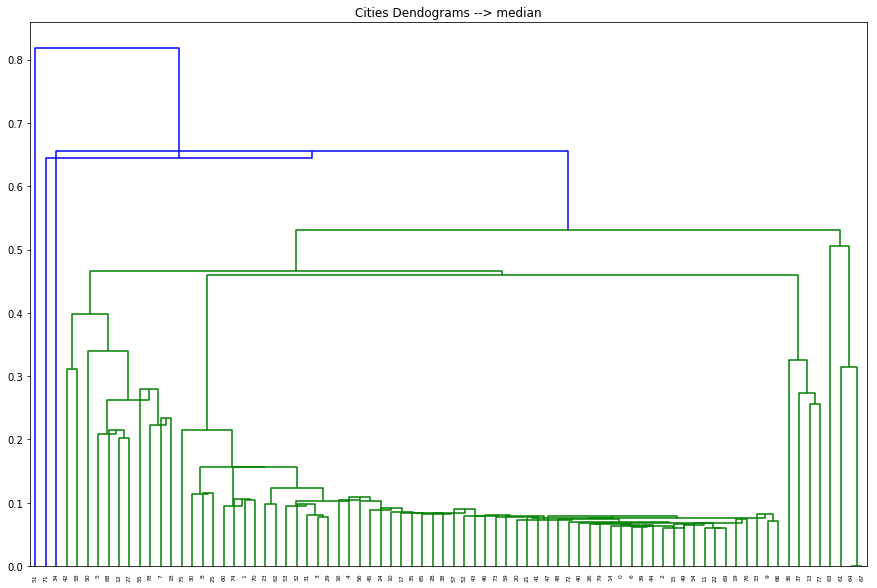

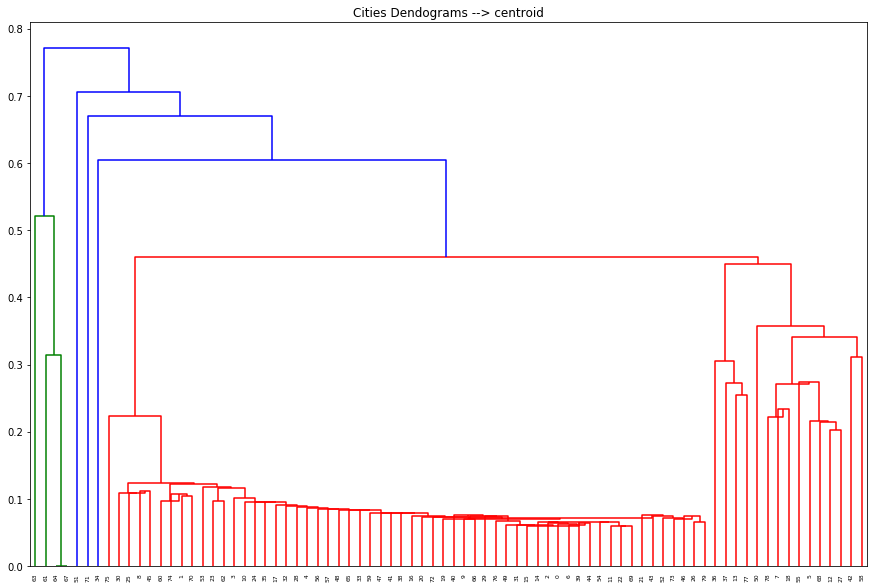

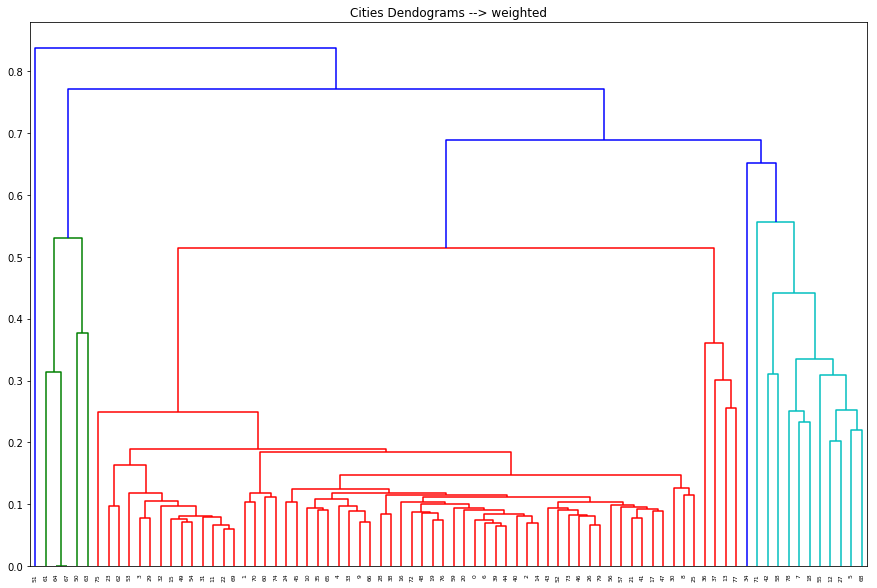

In [330]:
#fig, axes23 = plt.subplots(2, 3)
fig = plt.figure()
methods=['single', 'complete','median','centroid','weighted']
for method, num in zip(methods, range(0,len(methods))):
    plt.figure(figsize=(15, 10))  
    plt.title("Cities Dendograms --> "+str(method))
    dend = shc.dendrogram(shc.linkage(X, method=method))
    plt.show()


## We will use 7 clusters based on weighted hierarchical clustering plot

In [331]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='complete')  
cluster.fit(X)   


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='complete', memory=None,
            n_clusters=7, pooling_func=<function mean at 0x7fa288090d90>)

In [332]:
print(cluster.labels_)

[2 2 2 2 2 1 2 1 2 2 2 2 1 4 2 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 5 2 4
 4 2 2 2 2 1 2 2 2 2 2 2 2 0 3 2 2 2 1 2 2 1 2 2 0 2 0 0 2 2 0 1 2 2 6 2 2
 2 2 2 4 1 2]


In [333]:
city_venues_sorted_h=cities_grouped[:]
city_venues_sorted_h.insert(0, 'Cluster Labels Hierarchical', cluster.labels_)

In [334]:
city_venues_sorted_h.head()

,Cluster Labels Hierarchical,City,ATM,Accessories Store,Adult Boutique,Adult Education Center,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Borek Place,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Business Service,Cafeteria,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Churrascaria,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Administrative Building,College Cafeteria,College Classroom,College Engineering Building,College Library,College Math Building,College Technology Building,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currywurst Joint,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Halal Restaurant,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hobby Shop,Home Service,Hookah Bar,Hospital,Hospital Ward,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kumpir Restaurant,Language School,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lottery Retailer,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical School,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Non-Profit,Noodle House,Notary,Nursery School,Office,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Supply Store,Outlet Mall,Outlet Store,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pide Place,Pizza Place,Playground,Plaza,Poke Place,Polish Rest

Let's add coordinates to the dataset again to plot

In [335]:
city_merged_h = df_DeCl

# merge to add latitude/longitude for each neighborhood
city_merged_h = city_merged_h.join(city_venues_sorted_h.set_index('City'), on='City')
#clean nan values
city_merged_h=city_merged_h[np.isfinite(city_merged_h['Cluster Labels Hierarchical'])]
city_merged_h.head()

,city data link,City,Population,country data link,Country,Longitude,Latitude,Cluster Labels Hierarchical,ATM,Accessories Store,Adult Boutique,Adult Education Center,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Borek Place,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Business Service,Cafeteria,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Churrascaria,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Administrative Building,College Cafeteria,College Classroom,College Engineering Building,College Library,College Math Building,College Technology Building,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currywurst Joint,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Halal Restaurant,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hobby Shop,Home Service,Hookah Bar,Hospital,Hospital Ward,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kumpir Restaurant,Language School,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lottery Retailer,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical School,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Non-Profit,Noodle House,Notary,Nursery School,Office,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Supply Store,Outlet Mall,Outlet Store,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,P

In [336]:
# create map
map_clusters_h8 = folium.Map()

# set color scheme for the clusters
x = np.arange(9)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_merged_h['Latitude'], city_merged_h['Longitude'], city_merged_h['City'], city_merged_h['Cluster Labels Hierarchical']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-2],
        fill=True,
        fill_color=rainbow[int(cluster)-2],
        fill_opacity=0.7).add_to(map_clusters_h8)
       
map_clusters_h8

## Let's compare

In [337]:
i=0
for i in range(0,5):
    print('K-means for {} has {} cities' .format(i,city_merged.loc[city_merged['Cluster Labels K-Means'] == i].shape[0]))

K-means for 0 has 58 cities
K-means for 1 has 12 cities
K-means for 2 has 3 cities
K-means for 3 has 4 cities
K-means for 4 has 3 cities


In [338]:
i=0
for i in range(0,5):
    print('K-means for {} has {} cities' .format(i,city_merged_query.loc[city_merged_query['Cluster Labels K-Means Query'] == i].shape[0]))
    
    

K-means for 0 has 58 cities
K-means for 1 has 12 cities
K-means for 2 has 3 cities
K-means for 3 has 4 cities
K-means for 4 has 3 cities


In [339]:
i=0
for i in range(0,5):
    print('Hierarchical for {} has {} cities' .format(i,city_venues_sorted_h.loc[city_venues_sorted_h['Cluster Labels Hierarchical'] == i].shape[0]))
    
    

Hierarchical for 0 has 5 cities
Hierarchical for 1 has 10 cities
Hierarchical for 2 has 58 cities
Hierarchical for 3 has 1 cities
Hierarchical for 4 has 4 cities


# Look into a particular cluster

In [341]:
city_merged_h.head(3)

,city data link,City,Population,country data link,Country,Longitude,Latitude,Cluster Labels Hierarchical,ATM,Accessories Store,Adult Boutique,Adult Education Center,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Borek Place,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Business Service,Cafeteria,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Churrascaria,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Administrative Building,College Cafeteria,College Classroom,College Engineering Building,College Library,College Math Building,College Technology Building,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currywurst Joint,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Halal Restaurant,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hobby Shop,Home Service,Hookah Bar,Hospital,Hospital Ward,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kumpir Restaurant,Language School,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lottery Retailer,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical School,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Non-Profit,Noodle House,Notary,Nursery School,Office,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Supply Store,Outlet Mall,Outlet Store,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,P

in city_merged_h we have columns for Cluster Labels Hierarchical 5, Cluster Labels Hierarchical and Cluster Labels K-Means

In [342]:
#cluster_type='Cluster Labels K-Means'
cluster_type='Cluster Labels Hierarchical'


city_merged_h.loc[city_merged_h[cluster_type] == 3, 
                     city_merged_h.columns[[1] + list(range(5, city_merged_h.shape[1]))]]

,City,Longitude,Latitude,Cluster Labels Hierarchical,ATM,Accessories Store,Adult Boutique,Adult Education Center,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Borek Place,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Business Service,Cafeteria,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Churrascaria,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Administrative Building,College Cafeteria,College Classroom,College Engineering Building,College Library,College Math Building,College Technology Building,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currywurst Joint,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Halal Restaurant,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hobby Shop,Home Service,Hookah Bar,Hospital,Hospital Ward,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kumpir Restaurant,Language School,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lottery Retailer,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical School,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Non-Profit,Noodle House,Notary,Nursery School,Office,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Supply Store,Outlet Mall,Outlet Store,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pide Place,Pizza Place,Playground,Plaza,Pok

# Search for a particular city

In [343]:
search_city='Valparaíso'

city_merged_h.loc[city_merged_h['City'] == search_city, 
                     city_merged_h.columns[[1] + list(range(5, city_merged_h.shape[1]))]]

,City,Longitude,Latitude,Cluster Labels Hierarchical,ATM,Accessories Store,Adult Boutique,Adult Education Center,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Borek Place,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Business Service,Cafeteria,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Churrascaria,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Administrative Building,College Cafeteria,College Classroom,College Engineering Building,College Library,College Math Building,College Technology Building,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currywurst Joint,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Halal Restaurant,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hobby Shop,Home Service,Hookah Bar,Hospital,Hospital Ward,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kumpir Restaurant,Language School,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lottery Retailer,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical School,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Non-Profit,Noodle House,Notary,Nursery School,Office,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Supply Store,Outlet Mall,Outlet Store,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pide Place,Pizza Place,Playground,Plaza,Pok

In [344]:
city_merged_h.loc[city_merged_h.apply(lambda row: row.astype(str).str.contains('Zoo').any(), axis=1), 
                     city_merged_h.columns[[1] + list(range(5, city_merged_h.shape[1]))]]

,City,Longitude,Latitude,Cluster Labels Hierarchical,ATM,Accessories Store,Adult Boutique,Adult Education Center,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Borek Place,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Business Service,Cafeteria,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Churrascaria,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Administrative Building,College Cafeteria,College Classroom,College Engineering Building,College Library,College Math Building,College Technology Building,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currywurst Joint,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Halal Restaurant,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hobby Shop,Home Service,Hookah Bar,Hospital,Hospital Ward,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kumpir Restaurant,Language School,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lottery Retailer,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical School,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Non-Profit,Noodle House,Notary,Nursery School,Office,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Supply Store,Outlet Mall,Outlet Store,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pide Place,Pizza Place,Playground,Plaza,Pok

In [345]:
city_merged_h[city_merged_h['Cluster Labels Hierarchical'] == 2.0]

,city data link,City,Population,country data link,Country,Longitude,Latitude,Cluster Labels Hierarchical,ATM,Accessories Store,Adult Boutique,Adult Education Center,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Borek Place,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Business Service,Cafeteria,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Churrascaria,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Administrative Building,College Cafeteria,College Classroom,College Engineering Building,College Library,College Math Building,College Technology Building,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currywurst Joint,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Halal Restaurant,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hobby Shop,Home Service,Hookah Bar,Hospital,Hospital Ward,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kumpir Restaurant,Language School,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lottery Retailer,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical School,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Non-Profit,Noodle House,Notary,Nursery School,Office,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Supply Store,Outlet Mall,Outlet Store,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,P

## Most frequent venues for each cluster

**let's check the venues for each cluster using foursquare categories for the analysis**

In [346]:
city_venues_sorted_h.head()

,Cluster Labels Hierarchical,City,ATM,Accessories Store,Adult Boutique,Adult Education Center,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Borek Place,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Business Service,Cafeteria,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Churrascaria,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Administrative Building,College Cafeteria,College Classroom,College Engineering Building,College Library,College Math Building,College Technology Building,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currywurst Joint,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Halal Restaurant,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hobby Shop,Home Service,Hookah Bar,Hospital,Hospital Ward,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kumpir Restaurant,Language School,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lottery Retailer,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical School,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Non-Profit,Noodle House,Notary,Nursery School,Office,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Supply Store,Outlet Mall,Outlet Store,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pide Place,Pizza Place,Playground,Plaza,Poke Place,Polish Rest

In [347]:
# one hot encoding

city_venues_sorted_ho = city_venues_sorted_h.drop('City',axis=1)
city_venues_sorted_ho = city_venues_sorted_ho.drop('Cluster Labels Hierarchical', axis=1)
cities_onehot_h = pd.get_dummies(city_venues_sorted_ho[9:], prefix="", prefix_sep="")

# add city column back to dataframe
cities_onehot_h['Cluster Labels Hierarchical'] = city_venues_sorted_h['Cluster Labels Hierarchical']

# move city column to the first column
fixed_columns = [cities_onehot_h.columns[-1]] + list(cities_onehot_h.columns[:-1])
cities_onehot_h = cities_onehot_h[fixed_columns]

cities_onehot_h.head()

,Cluster Labels Hierarchical,ATM,Accessories Store,Adult Boutique,Adult Education Center,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Borek Place,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Business Service,Cafeteria,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Churrascaria,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Administrative Building,College Cafeteria,College Classroom,College Engineering Building,College Library,College Math Building,College Technology Building,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currywurst Joint,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Halal Restaurant,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hobby Shop,Home Service,Hookah Bar,Hospital,Hospital Ward,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kumpir Restaurant,Language School,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lottery Retailer,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical School,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Non-Profit,Noodle House,Notary,Nursery School,Office,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Supply Store,Outlet Mall,Outlet Store,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pide Place,Pizza Place,Playground,Plaza,Poke Place,Polish Restauran

In [348]:
cities_grouped_h = cities_onehot_h.groupby('Cluster Labels Hierarchical').mean().reset_index()
cities_grouped_h.head()

,Cluster Labels Hierarchical,ATM,Accessories Store,Adult Boutique,Adult Education Center,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Borek Place,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Business Service,Cafeteria,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Churrascaria,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Administrative Building,College Cafeteria,College Classroom,College Engineering Building,College Library,College Math Building,College Technology Building,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currywurst Joint,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Halal Restaurant,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hobby Shop,Home Service,Hookah Bar,Hospital,Hospital Ward,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kumpir Restaurant,Language School,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lottery Retailer,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical School,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Non-Profit,Noodle House,Notary,Nursery School,Office,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Supply Store,Outlet Mall,Outlet Store,Pakistani Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pide Place,Pizza Place,Playground,Plaza,Poke Place,Polish Restauran

In [349]:
num_top_venues = 5

for city in cities_grouped_h['Cluster Labels Hierarchical']:
    print("----"+str(city)+"----")
    temp = cities_grouped_h[cities_grouped_h['Cluster Labels Hierarchical'] == city].T.reset_index()
    #print(temp)
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----0----
             venue  freq
0           School  0.77
1  Automotive Shop  0.11
2      High School  0.04
3  Language School  0.03
4   Private School  0.03


----1----
             venue  freq
0           School  0.41
1      High School  0.25
2     Music School  0.16
3  Language School  0.06
4   Driving School  0.04


----2----
                venue  freq
0                Café  0.12
1         Supermarket  0.06
2      Clothing Store  0.03
3              Bakery  0.03
4  Italian Restaurant  0.03


----3----
           venue  freq
0   Music School  0.67
1         School  0.33
2            ATM  0.00
3  Movie Theater  0.00
4     Non-Profit  0.00


----4----
             venue  freq
0       University  0.40
1           School  0.25
2  Language School  0.13
3      High School  0.11
4   Driving School  0.04


----5----
            venue  freq
0  Driving School  0.55
1     High School  0.27
2          School  0.18
3   Movie Theater  0.00
4      Non-Profit  0.00


----6----
            venue 

**it's really hard to see the differences because foursquare returns to many categories**

**Let's do the same with our queries instead of the categories**

In [350]:
Xq = cities_grouped_query.drop('City', axis=1)
Xq.head()

,coffee,entertainment,hospital,nightlife,playground,restaurant,school,shops,university
0,0.138599,0.010432,0.013413,0.168405,0.013413,0.298063,0.034277,0.298063,0.025335
1,0.063014,0.030137,0.013699,0.090411,0.035616,0.298630,0.046575,0.386301,0.035616
2,0.121368,0.011966,0.008547,0.169231,0.005128,0.305983,0.035897,0.329915,0.011966
3,0.193611,0.070668,0.033882,0.193611,0.024201,0.193611,0.091965,0.193611,0.004840
4,0.124122,0.016393,0.025761,0.114754,0.035129,0.288056,0.025761,0.358314,0.011710


In [351]:
cities_grouped_query.head()

,City,coffee,entertainment,hospital,nightlife,playground,restaurant,school,shops,university
0,Aachen,0.138599,0.010432,0.013413,0.168405,0.013413,0.298063,0.034277,0.298063,0.025335
1,Antofagasta,0.063014,0.030137,0.013699,0.090411,0.035616,0.298630,0.046575,0.386301,0.035616
2,Augsburg,0.121368,0.011966,0.008547,0.169231,0.005128,0.305983,0.035897,0.329915,0.011966
3,Berlin,0.193611,0.070668,0.033882,0.193611,0.024201,0.193611,0.091965,0.193611,0.004840
4,Bielefeld,0.124122,0.016393,0.025761,0.114754,0.035129,0.288056,0.025761,0.358314,0.011710


In [352]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='complete')  
cluster.fit(Xq)   


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='complete', memory=None,
            n_clusters=7, pooling_func=<function mean at 0x7fa288090d90>)

In [353]:
city_venues_sorted_hq=cities_grouped_query[:]
city_venues_sorted_hq.insert(0, 'Cluster Labels Hierarchical', cluster.labels_)
city_venues_sorted_hq=city_venues_sorted_hq.drop('City',axis=1)

In [354]:
city_venues_sorted_hq.head()

,Cluster Labels Hierarchical,coffee,entertainment,hospital,nightlife,playground,restaurant,school,shops,university
0,1,0.138599,0.010432,0.013413,0.168405,0.013413,0.298063,0.034277,0.298063,0.025335
1,3,0.063014,0.030137,0.013699,0.090411,0.035616,0.298630,0.046575,0.386301,0.035616
2,1,0.121368,0.011966,0.008547,0.169231,0.005128,0.305983,0.035897,0.329915,0.011966
3,2,0.193611,0.070668,0.033882,0.193611,0.024201,0.193611,0.091965,0.193611,0.004840
4,3,0.124122,0.016393,0.025761,0.114754,0.035129,0.288056,0.025761,0.358314,0.011710


In [355]:
# one hot encoding

#city_venues_sorted_hq = cities_grouped_query.drop('City',axis=1)
city_venues_sorted_hq1 = city_venues_sorted_hq.drop('Cluster Labels Hierarchical', axis=1)
#city_venues_sorted_hq1 = city_venues_sorted_hq1.drop('City', axis=1)
cities_onehot_hq = pd.get_dummies(city_venues_sorted_hq[9:], prefix="", prefix_sep="")

# add city column back to dataframe
cities_onehot_hq['Cluster Labels Hierarchical'] = city_venues_sorted_hq['Cluster Labels Hierarchical']
#print(cities_onehot_hq.head())
# move city column to the first column
fixed_columns = [cities_onehot_hq.columns[-1]] + list(cities_onehot_hq.columns[:-1])
cities_onehot_hq = cities_onehot_hq[fixed_columns]

cities_onehot_hq.head()

,university,Cluster Labels Hierarchical,coffee,entertainment,hospital,nightlife,playground,restaurant,school,shops
9,0.022659,1,0.119335,0.022659,0.010574,0.122356,0.074018,0.300604,0.025680,0.302115
10,0.010753,3,0.079570,0.015054,0.010753,0.109677,0.019355,0.307527,0.036559,0.410753
11,0.016077,2,0.214362,0.026795,0.018221,0.214362,0.009646,0.214362,0.071811,0.214362
12,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
13,0.346154,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.653846,0.000000


In [356]:
cities_grouped_hq = cities_onehot_hq.groupby('Cluster Labels Hierarchical').mean().reset_index()
cities_grouped_hq.head()

,Cluster Labels Hierarchical,university,coffee,entertainment,hospital,nightlife,playground,restaurant,school,shops
0,0,0.016204,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.983796,0.000000
1,1,0.021645,0.135617,0.017628,0.018556,0.150190,0.024544,0.310969,0.039688,0.281163
2,2,0.015086,0.203771,0.018707,0.014576,0.213681,0.014576,0.226529,0.066546,0.226529
3,3,0.021339,0.129860,0.019761,0.021048,0.046805,0.009591,0.316476,0.036779,0.398341
4,4,0.011490,0.050547,0.036456,0.015934,0.000000,0.000000,0.209703,0.028039,0.647831


In [357]:
num_top_venues = 3

for city in cities_grouped_hq['Cluster Labels Hierarchical']:
    print("----"+str(city)+"----")
    temp = cities_grouped_hq[cities_grouped_hq['Cluster Labels Hierarchical'] == city].T.reset_index()
    #print(temp)
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----0----
        venue  freq
0      school  0.98
1  university  0.02
2      coffee  0.00


----1----
        venue  freq
0  restaurant  0.31
1       shops  0.28
2   nightlife  0.15


----2----
        venue  freq
0  restaurant  0.23
1       shops  0.23
2   nightlife  0.21


----3----
        venue  freq
0       shops  0.40
1  restaurant  0.32
2      coffee  0.13


----4----
        venue  freq
0       shops  0.65
1  restaurant  0.21
2      coffee  0.05


----5----
        venue  freq
0  restaurant  0.30
1  university  0.20
2       shops  0.18


----6----
        venue  freq
0      school  0.64
1  university  0.36
2      coffee  0.00




Now we can better see the differences between the clustes. 

**Cluster 0**
venue  freq
0      school  0.98
1  university  0.02



**Cluster 1**
        venue  freq
0  restaurant  0.31
1       shops  0.28
2   nightlife  0.15


**Cluster 2**
        venue  freq
0  restaurant  0.23
1       shops  0.23
2   nightlife  0.21


**Cluster 3**
        venue  freq
0       shops  0.40
1  restaurant  0.32
2      coffee  0.13


**Cluster 4**
        venue  freq
0       shops  0.65
1  restaurant  0.21
2      coffee  0.05


**Cluster 5**
        venue  freq
0  restaurant  0.30
1  university  0.20
2       shops  0.18


**Cluster 6**
        venue  freq
0      school  0.64
1  university  0.36
